# BERT as a Feature Extractor + Machine Learning Classifier (BERT Embedding + Machine Learning Classifier)

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/test_cleaned_category_email_dataset_machine_learning_model.csv')

Mounted at /content/drive


<ipython-input-1-c88b8fce1b3d>:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/test_cleaned_category_email_dataset_machine_learning_model.csv')


In [ ]:
email_data['Combined_Text'] = email_data['Cleaned_Subject'].fillna('') + ' ' + email_data['Cleaned_Message'].fillna('')

In [ ]:
# Assume email_data contains your full dataset
# Column names: Combined_Text, Category, Cleaned_Subject, Cleaned_Message, etc.

def partial_undersample(df, target_col='Category', cap=15000):
    balanced_list = []
    for label, group in df.groupby(target_col):
        if len(group) > cap:
            sampled = group.sample(n=cap, random_state=42)
        else:
            sampled = group
        balanced_list.append(sampled)
    return pd.concat(balanced_list).reset_index(drop=True)

# Apply the undersampling
partially_balanced_email_data = partial_undersample(email_data, target_col='Category', cap=15000)

# Check the new distribution
print(partially_balanced_email_data['Category'].value_counts())

Category
Finance & Transaction Email               15000
Meeting & Schedule Email                  15000
Legal & Contractual Email                 15000
Personal Email                            15000
Work or Business Email                    15000
Spam Email                                11807
IT Alerts & System Notifications Email    11347
Internal Policies & HR Updates Email       8837
Social Media Email                         7405
Promotions or Marketing Email              7379
Utilities Bill Email                       7323
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

email_data['Category'].value_counts().plot(kind='bar', figsize=(10,6))

plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Split into Train and Test
X = partially_balanced_email_data['Combined_Text']
y = partially_balanced_email_data['Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# === BERT Embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_train_embed = embedder.encode(X_train.tolist(), show_progress_bar=True)
X_test_embed = embedder.encode(X_test.tolist(), show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3228 [00:00<?, ?it/s]

Batches:   0%|          | 0/807 [00:00<?, ?it/s]

# SVM

✅ Accuracy: 0.8344306738962045
📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.72      0.73      0.72      3000
IT Alerts & System Notifications Email       0.89      0.93      0.91      2269
  Internal Policies & HR Updates Email       0.92      0.88      0.90      1767
             Legal & Contractual Email       0.77      0.83      0.80      3000
              Meeting & Schedule Email       0.84      0.83      0.84      3000
                        Personal Email       0.80      0.82      0.81      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      1.00      1.00      1481
                            Spam Email       0.92      0.90      0.91      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
                Work or Business Email       0.63      0.58    

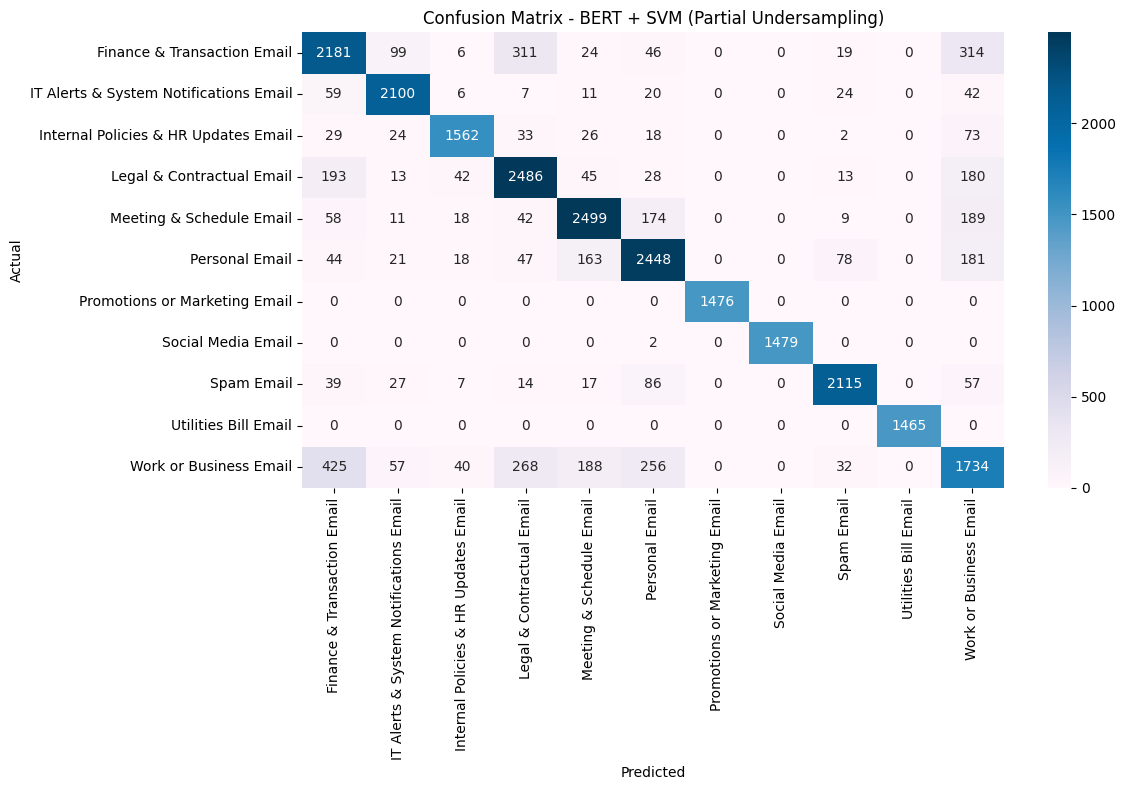

In [ ]:
# === SVM Model
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_embed, y_train_encoded)

# === Predictions
y_pred = svm_model.predict(X_test_embed)

# === Evaluation
print("✅ Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + SVM (Partial Undersampling)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#SVM Learning Curve

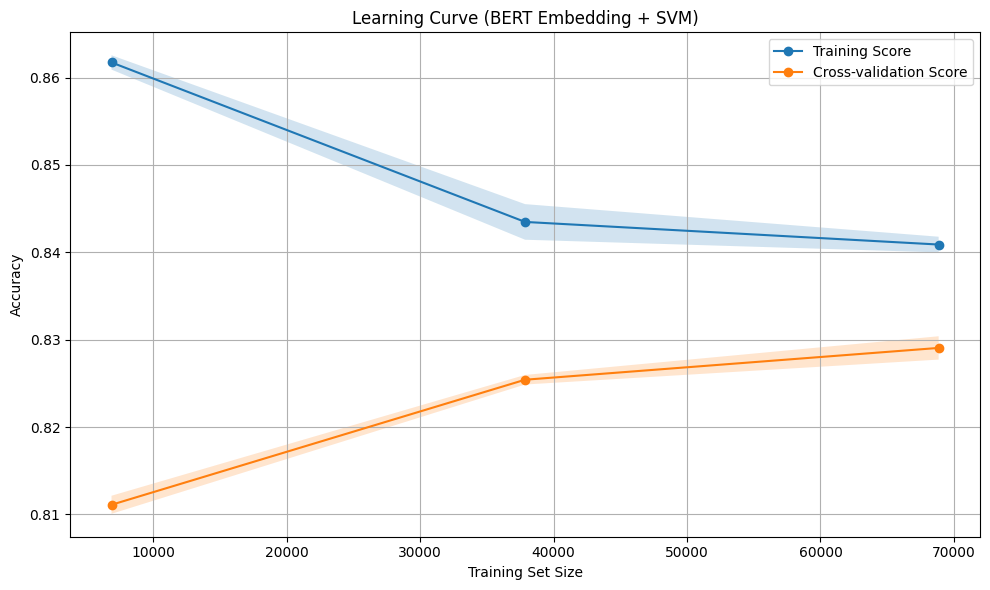

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    svm_model,
    X_train_embed,
    y_train_encoded,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 3),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)

plt.title('Learning Curve (BERT Embedding + SVM)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# LR

🧠 Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Accuracy (BERT + Logistic Regression): 0.8277691711851278

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.70      0.71      0.71      3000
IT Alerts & System Notifications Email       0.88      0.92      0.90      2269
  Internal Policies & HR Updates Email       0.92      0.88      0.90      1767
             Legal & Contractual Email       0.77      0.82      0.79      3000
              Meeting & Schedule Email       0.83      0.83      0.83      3000
                        Personal Email       0.79      0.82      0.80      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      1.00      1.00      1481
                            Spam Email       0.91      0.89      0.90      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
                Work or Business 

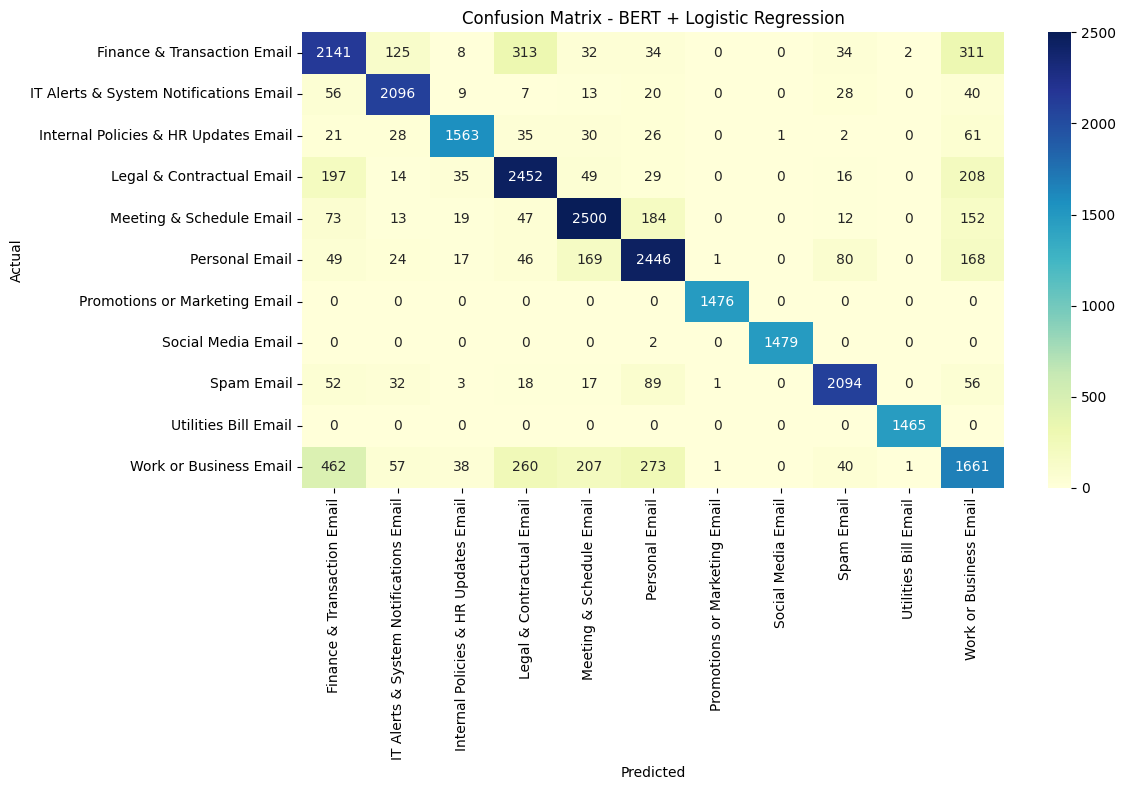

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 5: Train Logistic Regression model
print("🧠 Training Logistic Regression...")
lr_model = LogisticRegression(
    solver='liblinear',
    multi_class='ovr',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_embed, y_train_encoded)

# === Step 6: Evaluate the model
y_pred = lr_model.predict(X_test_embed)

print("✅ Accuracy (BERT + Logistic Regression):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 7: Plot confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# LR Learning Curve

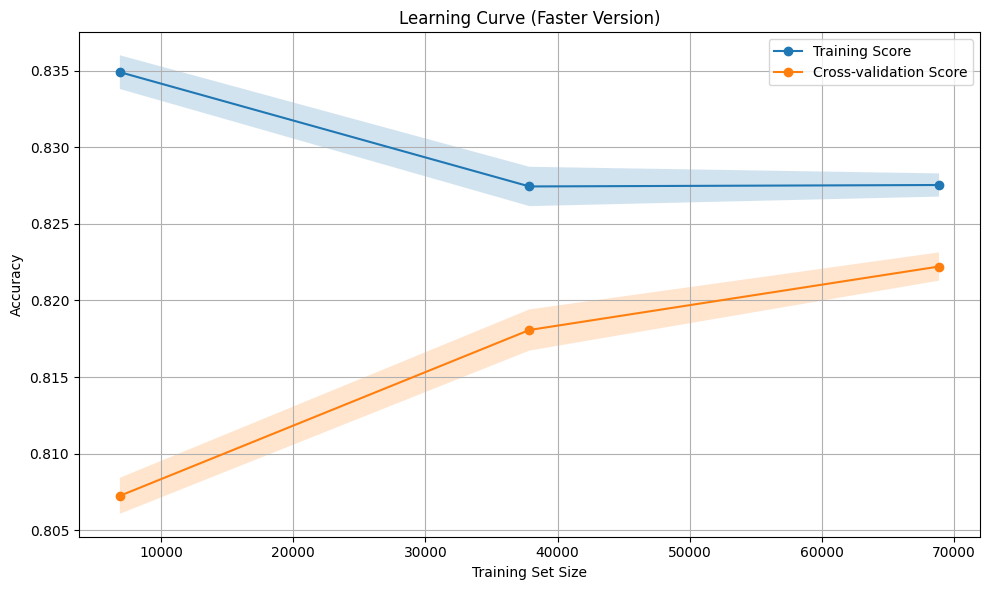

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    lr_model,
    X_train_embed,
    y_train_encoded,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 3),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)

plt.title('Learning Curve (Faster Version)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#RF

🌲 Training Random Forest...
✅ Accuracy (BERT + Random Forest): 0.8197908597986058

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.73      0.72      0.73      3000
IT Alerts & System Notifications Email       0.98      0.87      0.92      2269
  Internal Policies & HR Updates Email       1.00      0.85      0.92      1767
             Legal & Contractual Email       0.75      0.84      0.79      3000
              Meeting & Schedule Email       0.84      0.80      0.82      3000
                        Personal Email       0.71      0.85      0.77      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      0.98      0.99      1481
                            Spam Email       0.99      0.82      0.90      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
           

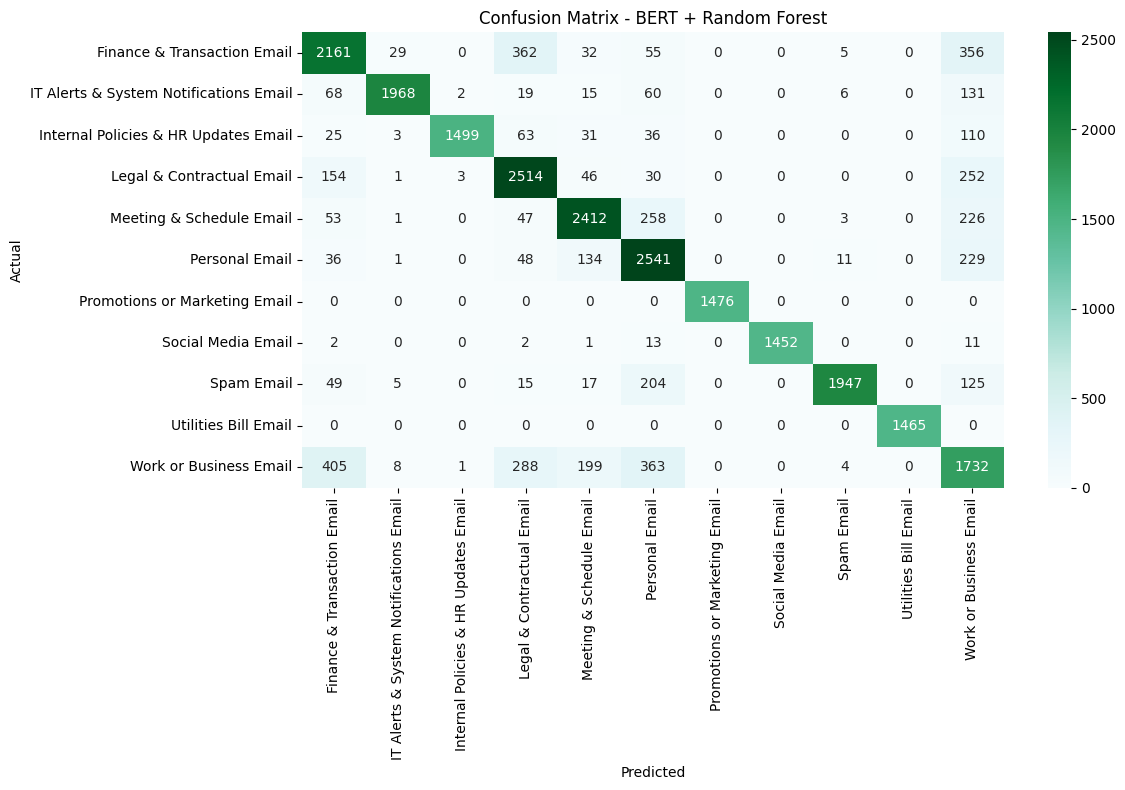

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Step 5: Train Random Forest classifier
print("🌲 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_embed, y_train_encoded)

# === Step 6: Evaluate
y_pred = rf_model.predict(X_test_embed)

print("✅ Accuracy (BERT + Random Forest):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuGn',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# RF Learning Curve

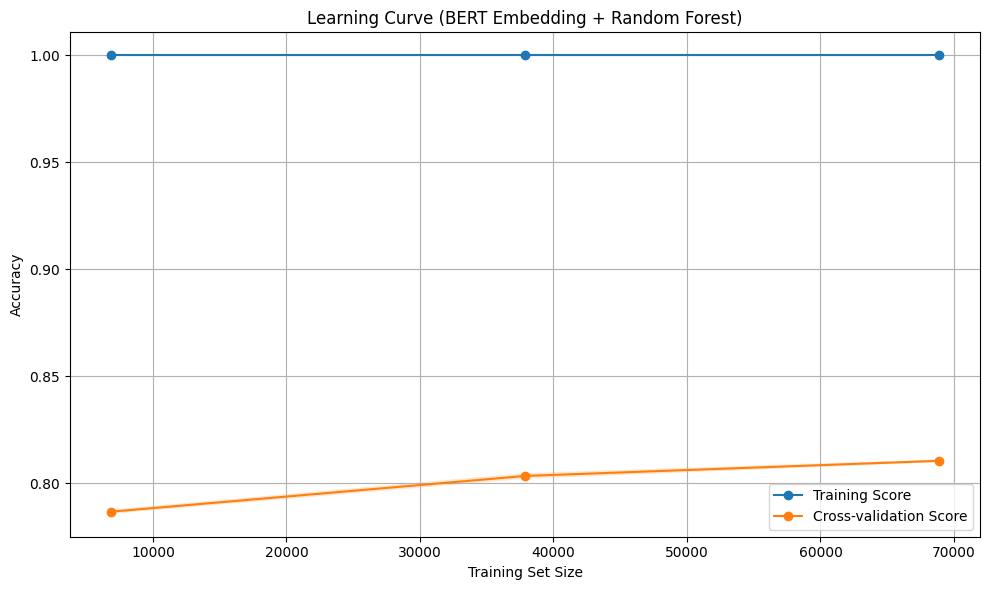

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    rf_model,
    X_train_embed,
    y_train_encoded,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 3),
    shuffle=True,
    random_state=42
)

# === Step 2: Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# === Step 3: Plot learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)

plt.title('Learning Curve (BERT Embedding + Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#XG Boost

🚀 Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:43:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy (BERT + XGBoost): 0.8402013942680093

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.75      0.75      0.75      3000
IT Alerts & System Notifications Email       0.96      0.91      0.94      2269
  Internal Policies & HR Updates Email       0.98      0.87      0.92      1767
             Legal & Contractual Email       0.78      0.83      0.80      3000
              Meeting & Schedule Email       0.85      0.83      0.84      3000
                        Personal Email       0.78      0.83      0.81      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      0.99      1.00      1481
                            Spam Email       0.96      0.88      0.92      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
                Work or Business Email       

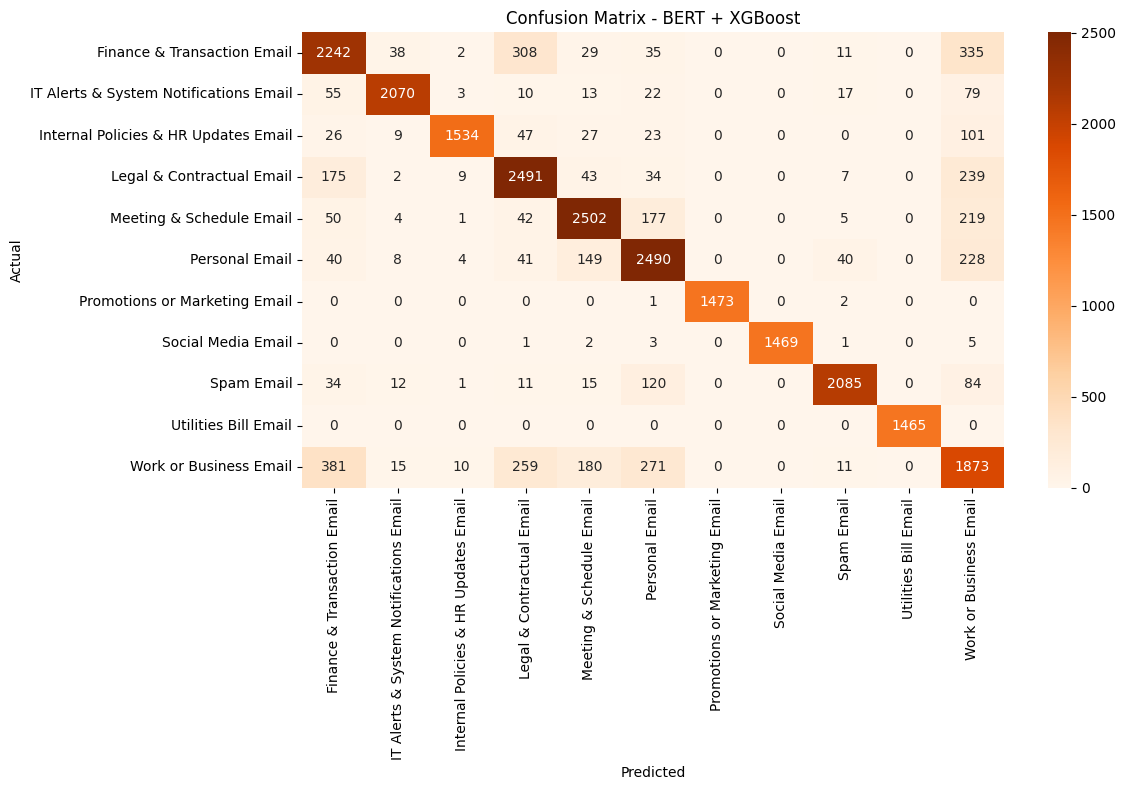

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("🚀 Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    n_estimators=250,
    learning_rate=0.1,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    tree_method='hist',
    random_state=42
)

xgb_model.fit(X_train_embed, y_train_encoded)

y_pred = xgb_model.predict(X_test_embed)

print("✅ Accuracy (BERT + XGBoost):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#XGBoost Learning Curve

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


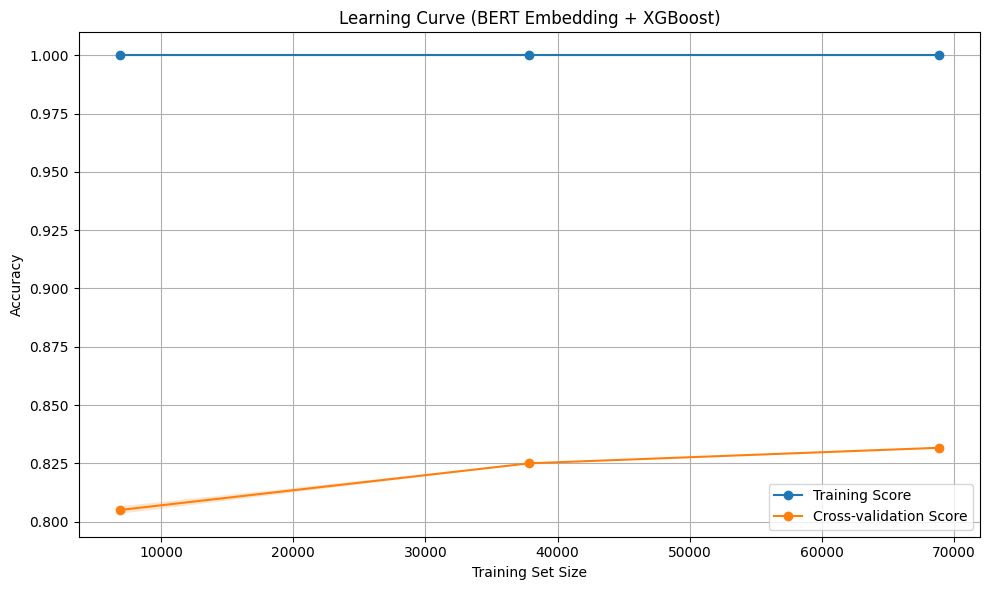

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model,
    X_train_embed,
    y_train_encoded,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 3),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)

plt.title('Learning Curve (BERT Embedding + XGBoost)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Naive Bayes

✅ Accuracy (BERT + GaussianNB): 0.7633617350890782

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.64      0.66      0.65      3000
IT Alerts & System Notifications Email       0.93      0.80      0.86      2269
  Internal Policies & HR Updates Email       1.00      0.80      0.89      1767
             Legal & Contractual Email       0.76      0.74      0.75      3000
              Meeting & Schedule Email       0.84      0.74      0.79      3000
                        Personal Email       0.69      0.80      0.74      3000
         Promotions or Marketing Email       1.00      0.97      0.98      1476
                    Social Media Email       1.00      0.92      0.96      1481
                            Spam Email       0.97      0.69      0.81      2362
                  Utilities Bill Email       1.00      0.93      0.96      1465
                Work or Business Email    

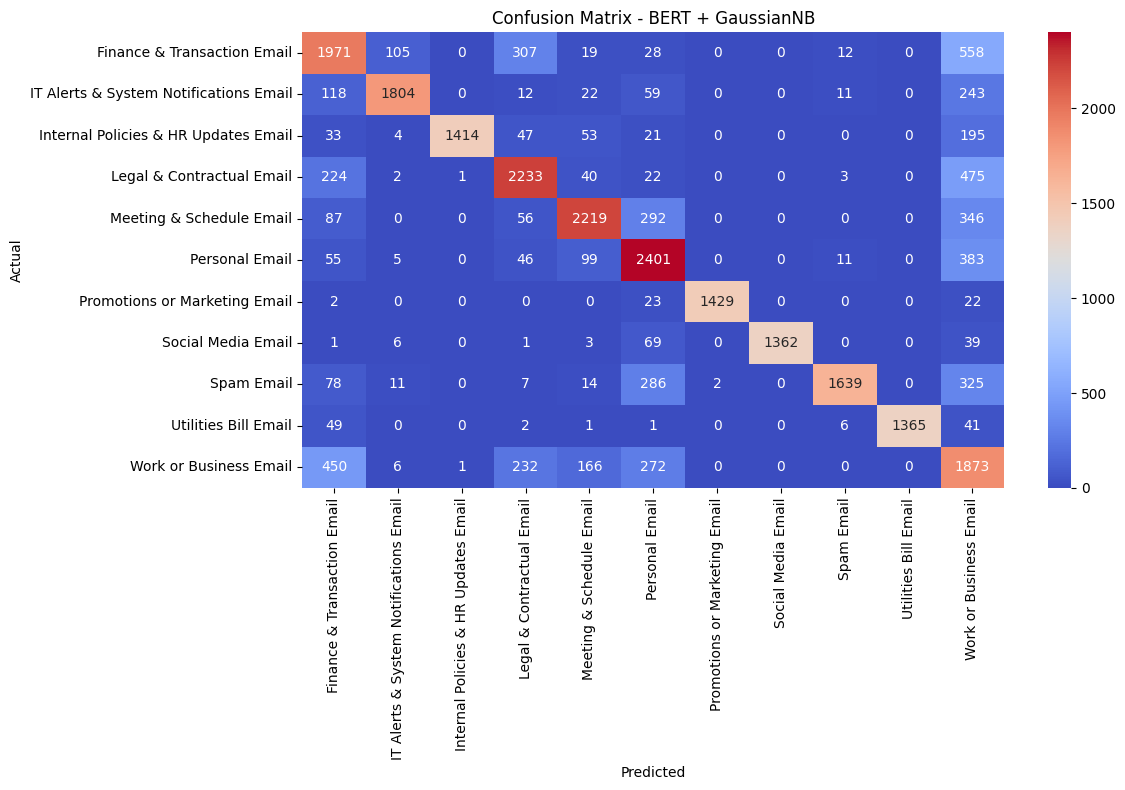

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Initialize and train
nb_model = GaussianNB()
nb_model.fit(X_train_embed, y_train_encoded)

# === Step 2: Predict
y_pred = nb_model.predict(X_test_embed)

# === Step 3: Evaluate
print("✅ Accuracy (BERT + GaussianNB):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + GaussianNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Naive Bayes Learning Curve

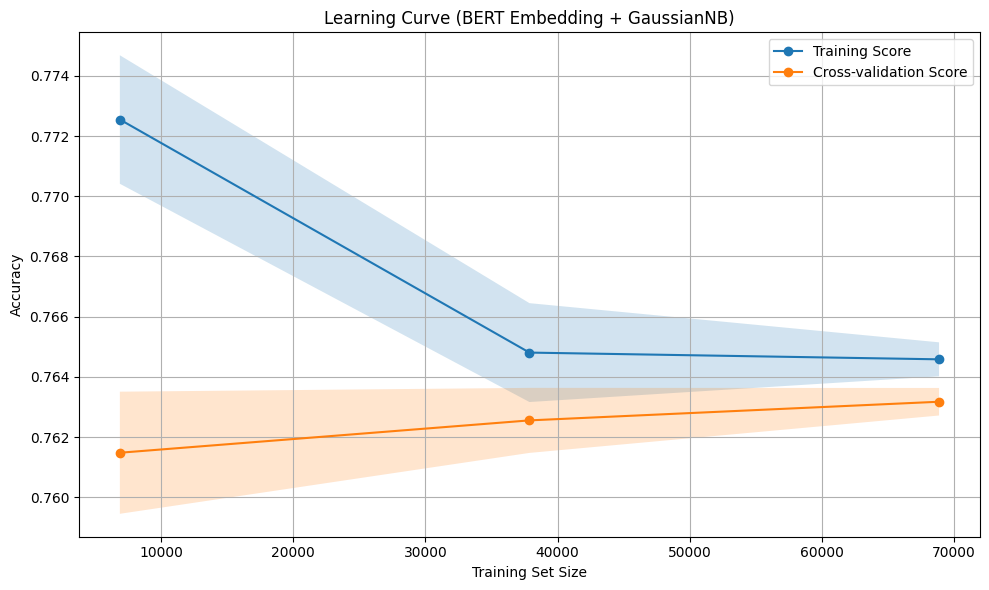

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    nb_model,
    X_train_embed,
    y_train_encoded,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 3),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)

plt.title('Learning Curve (BERT Embedding + GaussianNB)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Hybrid Model

In [ ]:
import joblib

# Load the base models from your saved files
lr_model = joblib.load('/content/drive/MyDrive/bert_categorazation_models/bert_lr_model.joblib')
rf_model = joblib.load('/content/drive/MyDrive/bert_categorazation_models/bert_rf_model.joblib')
svm_model = joblib.load('/content/drive/MyDrive/bert_categorazation_models/bert_svm_model.joblib')
xgb_model = joblib.load('/content/drive/MyDrive/bert_categorazation_models/bert_xgb_model.joblib')

print("✅ Base models (LR, RF, SVM, XGB) loaded successfully!")

✅ Base models (LR, RF, SVM, XGB) loaded successfully!


In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft',         # Soft = probability averaging
    weights=[2, 2, 1, 3],   # Weighted voting (you can tune this)
    n_jobs=-1
)

# === Step 4: Fit hybrid model
print("🚀 Training Hybrid Voting Classifier...")
voting_model.fit(X_train_embed, y_train_encoded)

# === Step 5: Predict
y_pred = voting_model.predict(X_test_embed)

# === Step 6: Evaluate
print("✅ Accuracy (BERT + Hybrid Ensemble):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Hybrid Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

🚀 Training Hybrid Voting Classifier...


In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    voting_model,
    X_train_embed,
    y_train_encoded,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 3),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)

plt.title('Learning Curve (BERT Embedding + Hybrid Voting Classifier)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Models

In [ ]:
import joblib
import os
import numpy as np

save_dir = "/content/drive/MyDrive/bert_categorazation_models"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(lr_model, os.path.join(save_dir, 'bert_lr_model.joblib'))        # Logistic Regression
joblib.dump(rf_model, os.path.join(save_dir, 'bert_rf_model.joblib'))        # Random Forest
joblib.dump(svm_model, os.path.join(save_dir, 'bert_svm_model.joblib'))      # SVM
joblib.dump(xgb_model, os.path.join(save_dir, 'bert_xgb_model.joblib'))      # XGBoost
joblib.dump(nb_model, os.path.join(save_dir, 'bert_nb_model.joblib'))        # Gaussian Naive Bayes
joblib.dump(voting_model, os.path.join(save_dir, 'bert_hybrid_soft_model.joblib'))  # Hybrid Soft Voting

joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.joblib'))

embedder.save(os.path.join(save_dir, 'bert_embedder_model'))

# Model Comparison

Logistic Regression Accuracy: 0.8278
Random Forest Accuracy: 0.8198
SVM Accuracy: 0.8344
XGBoost Accuracy: 0.8402
Hybrid Voting Ensemble Accuracy: 0.8433


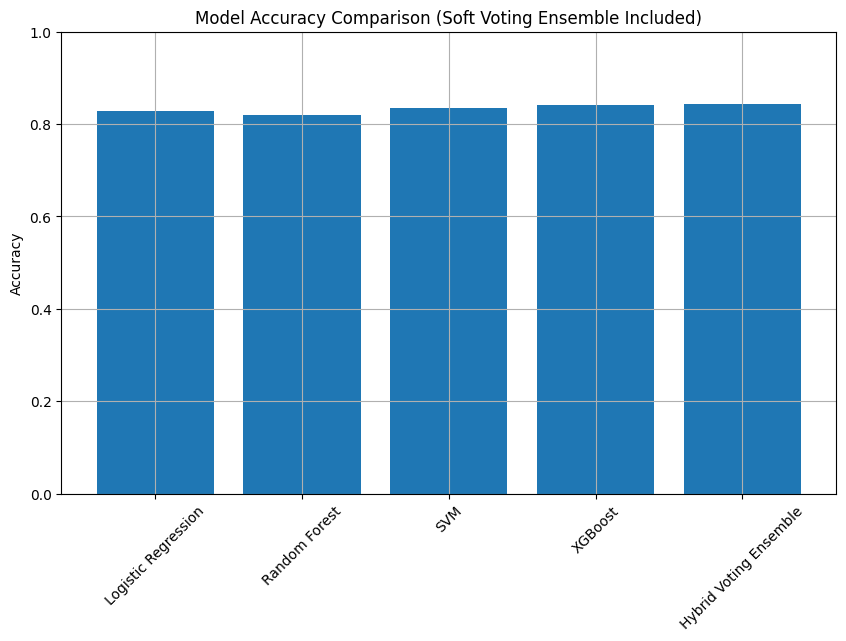

In [ ]:
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'Hybrid Voting Ensemble': voting_model
}

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test_embed)
    acc = accuracy_score(y_test_encoded, y_pred)
    results[model_name] = acc
    print(f"{model_name} Accuracy: {acc:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Soft Voting Ensemble Included)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# BERT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')

# Load your email dataset
email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/test_cleaned_category_email_dataset_machine_learning_model.csv')

# Combine Cleaned_Subject + Cleaned_Message
email_data['Combined_Text'] = email_data['Cleaned_Subject'].fillna('') + ' ' + email_data['Cleaned_Message'].fillna('')

# Partial undersampling to balance
def partial_undersample(df, target_col='Category', cap=15000):
    balanced_list = []
    for label, group in df.groupby(target_col):
        if len(group) > cap:
            sampled = group.sample(n=cap, random_state=42)
        else:
            sampled = group
        balanced_list.append(sampled)
    return pd.concat(balanced_list).reset_index(drop=True)

partially_balanced_email_data = partial_undersample(email_data, target_col='Category', cap=15000)

# Split into features and target
X = partially_balanced_email_data['Combined_Text']
y = partially_balanced_email_data['Category']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Number of classes
num_classes = len(label_encoder.classes_)
print(f"✅ Number of classes: {num_classes}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-ac2d3c35ebd5>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/test_cleaned_category_email_dataset_machine_learning_model.csv')


✅ Number of classes: 11


In [ ]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
from torch.utils.data import Dataset

class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create datasets
train_dataset = EmailDataset(train_encodings, y_train)
test_dataset = EmailDataset(test_encodings, y_test)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes
)

print("✅ BERT model loaded successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERT model loaded successfully!
